<a href="https://colab.research.google.com/github/ce888-sr/CE888_Lab/blob/main/A2/CE888_Assignment2_Model3_FineTuning_6epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Activation, Dropout, Dense, Conv2D, Flatten, Dropout, ReLU, MaxPool2D, BatchNormalization, SeparableConv2D, Add, GlobalAvgPool2D, GlobalAveragePooling2D
import cv2


In [2]:
#connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
#download and unzip files
#!unzip  "/content/gdrive/My Drive/Training (2).zip"
#!unzip  "/content/gdrive/My Drive/Test (1).zip"

In [11]:
train_directory = "/content/Training" #set directory to where the extracted datsets are saved
test_directory = '/content/Test'

In [12]:
#set image size and batch size
image_size = (254, 254)
batch_size = 32

In [13]:
#add data augmentation techniques to the training datagen and add rescale to all datagens
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8,0.9],
    validation_split=0.2)


val_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
#create datasets for training, validation and testing
train_ds = train_datagen.flow_from_directory(
    train_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed = 1337,
    subset='training') # set as training data

val_ds = val_datagen.flow_from_directory(
    train_directory, # same directory as training data
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed = 1337,
    subset='validation') # set as validation data

test_ds = test_datagen.flow_from_directory(test_directory,
                                           target_size=image_size,
                                           batch_size=batch_size,
                                           class_mode='binary',
                                           shuffle = False)

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [26]:
#load pre trained Xception model
from keras.models import Model
from tensorflow.keras.applications import Xception # TensorFlow ONLY
from tensorflow.keras import regularizers

from keras.models import Model
#load pre trained Xception model
base_model = Xception(input_shape=(254, 254, 3), weights='imagenet', include_top=False) #define model
x = base_model.output

# add additional layers
x = GlobalAveragePooling2D()(x) #convert features to vectors
x = Dropout(0.5)(x) # add dropout 0.5
x = Dense(2048, activation = 'relu')(x)
x = Dropout(0.5)(x) # add dropout 0.5
output = Dense(1, activation='sigmoid')(x) #2 classes

#freeze the pre-trained base_model
for layer in base_model.layers: 
        layer.trainable = False 

model = Model(base_model.input, output)

#model.summary()

In [27]:
model.compile(optimizer=keras.optimizers.Adam(lr=1e-6), #low learning rate 
                  loss='binary_crossentropy',  # binary_crossentropy for binary classifier
                  metrics=['accuracy'])

In [29]:
#set early stopping and model weights checkpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
filepath = 'top_model.hdf5'
callbacks_list = [
   # EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True), #patience set to 5 to stop overfitting
    ModelCheckpoint(filepath, monitor ="val_loss", mode="min", save_best_only=True)]

In [30]:
epochs = 6
history = model.fit(train_ds,
          steps_per_epoch = 100, 
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=val_ds,
          #class_weight=class_weight,
          callbacks = callbacks_list)

Epoch 1/6
100/100 [==============================] - 73s 717ms/step - loss: 0.6365 - accuracy: 0.6611 - val_loss: 0.5758 - val_accuracy: 0.6472
Epoch 2/6
100/100 [==============================] - 71s 708ms/step - loss: 0.6015 - accuracy: 0.6837 - val_loss: 0.5349 - val_accuracy: 0.6822
Epoch 3/6
100/100 [==============================] - 71s 710ms/step - loss: 0.5837 - accuracy: 0.6859 - val_loss: 0.5026 - val_accuracy: 0.8583
Epoch 4/6
100/100 [==============================] - 71s 708ms/step - loss: 0.5366 - accuracy: 0.7575 - val_loss: 0.4707 - val_accuracy: 0.9799
Epoch 5/6
100/100 [==============================] - 71s 707ms/step - loss: 0.5118 - accuracy: 0.7697 - val_loss: 0.4430 - val_accuracy: 0.9978
Epoch 6/6
100/100 [==============================] - 71s 708ms/step - loss: 0.5039 - accuracy: 0.7841 - val_loss: 0.4214 - val_accuracy: 0.9999


In [31]:
for layer in model.layers[:95]:
 layer.trainable = False
for layer in model.layers[95:]:
 layer.trainable = True

In [32]:
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
                  loss='binary_crossentropy',  # binary_crossentropy for binary classifier
                  metrics=['accuracy'])

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
filepath='final_model.hdf5'
my_callbacks = [
    ModelCheckpoint(filepath, monitor ="val_loss", mode="min", save_best_only=True)]

In [34]:
history = model.fit(train_ds,
          steps_per_epoch = 100,
          batch_size=batch_size,
          epochs=15, 
          validation_data=val_ds,
          callbacks = my_callbacks)

Epoch 1/15
100/100 [==============================] - 74s 719ms/step - loss: 0.2491 - accuracy: 0.9063 - val_loss: 0.0231 - val_accuracy: 0.9881
Epoch 2/15
100/100 [==============================] - 71s 715ms/step - loss: 0.0389 - accuracy: 0.9871 - val_loss: 0.1196 - val_accuracy: 0.9707
Epoch 3/15
100/100 [==============================] - 71s 710ms/step - loss: 0.0221 - accuracy: 0.9911 - val_loss: 0.1461 - val_accuracy: 0.9693
Epoch 4/15
100/100 [==============================] - 71s 712ms/step - loss: 0.0328 - accuracy: 0.9924 - val_loss: 0.1397 - val_accuracy: 0.9647
Epoch 5/15
100/100 [==============================] - 71s 710ms/step - loss: 0.0177 - accuracy: 0.9948 - val_loss: 0.1813 - val_accuracy: 0.9581
Epoch 6/15
100/100 [==============================] - 71s 710ms/step - loss: 0.0110 - accuracy: 0.9956 - val_loss: 0.1886 - val_accuracy: 0.9647
Epoch 7/15
100/100 [==============================] - 71s 711ms/step - loss: 0.0154 - accuracy: 0.9941 - val_loss: 0.2520 - val_ac

In [64]:
test_ds.reset()
train_ds.reset()
val_ds.reset()

In [35]:
from sklearn.metrics import accuracy_score

testLabels = test_ds.classes.astype('int32')


## Test Accuracy
predictions = model.predict(test_ds)
y_pred = np.asarray(predictions).astype('int32').reshape((-1, 1))
y_pred = [1 if i> 0.5 else 0 for i in predictions]

test_acc = accuracy_score(testLabels, y_pred)

print(test_acc)

0.765579668097946


In [37]:
#test_scores.reset()
test_scores = model.evaluate(test_ds, batch_size=batch_size)

270/270 [==============================] - 26s 96ms/step - loss: 0.8997 - accuracy: 0.7656


In [ ]:
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(testLabels, y_pred, average='binary')

auc = roc_auc_score(testLabels, y_pred)

In [39]:
from sklearn.metrics import confusion_matrix, classification_report


fire_eval = confusion_matrix(testLabels, y_pred)
print(fire_eval)

target_names = ['Fire', 'No Fire']
print(classification_report(testLabels, y_pred, target_names=target_names))

[[4372  765]
 [1255 2225]]
              precision    recall  f1-score   support

        Fire       0.78      0.85      0.81      5137
     No Fire       0.74      0.64      0.69      3480

    accuracy                           0.77      8617
   macro avg       0.76      0.75      0.75      8617
weighted avg       0.76      0.77      0.76      8617



In [45]:
tp = fire_eval[0][0]
fp = fire_eval[0][1]
tn = fire_eval[1][0]
fn = fire_eval[1][1]
conmat = np.array([[tp, fn], [fp, tn]], dtype=int)

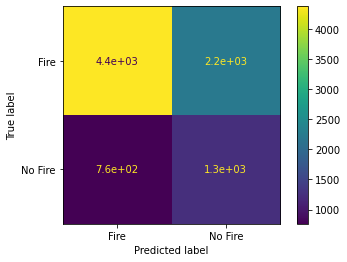

In [46]:
#plotconfusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cmat = ConfusionMatrixDisplay(confusion_matrix=conmat,

                              display_labels=target_names)
cmat.plot() 

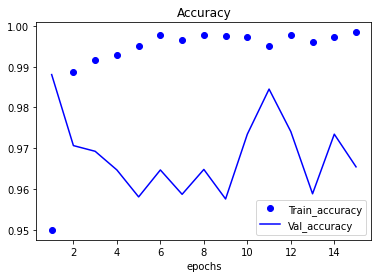

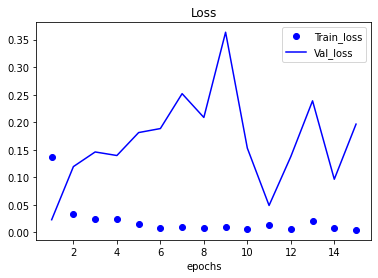

In [36]:
#create accuracy and loss plots over epochs to evaluate where to stop epoch
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Train_accuracy')
plt.plot(epochs, val_acc, 'b', label='Val_accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train_loss')
plt.plot(epochs, val_loss, 'b', label='Val_loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()

plt.show()

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
